In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from joblib import Parallel, delayed, parallel_config
from joblib_progress import joblib_progress

import lifesim
from lifesim.util.radiation import black_body

# set matplotlib style to default
plt.style.use('default')
# set matplotlib plot size to 258 pt
plt.rcParams["figure.figsize"] = (258/72, 200/72)

# 1. Baseline case, ET at 10 pc

In [3]:
setup = {'temp_p': 255.,
         'radius_p': 1.,
         'distance_s': 10.,
         'temp_s': 5778.,
         'radius_s': 1.,
         'lat_s': 0.79,
         'z': 3.,
         'opt_wl': 15.,
         'spec_res': 50,
         'integration_time': 10*24*60*60,
         'exposure_time': 30*60,
         'nrot': 9,
         'hyperrot_noise': 'max',
         }

setup['angsep'] = 1/setup['distance_s']

In [4]:
bus = lifesim.Bus()

# setting the options
bus.data.options.set_scenario('baseline')
bus.data.options.set_noise_scenario('earth-twin')
bus.data.options.set_manual(diameter=3., spec_res=50.)

bus.data.options.set_manual(rms_mode='wavelength',
                            d_phi_rms=0.,
                            d_a_rms=0.,
                            d_x_rms=0.,
                            d_y_rms=0.,
                            d_pol_rms=0.,
                            d_a_co=10e3,
                            d_phi_co=10e3,
                            d_pol_co=10e3,
                            d_x_co=0.64e-3,
                            d_y_co=0.64e-3)

# create modules and add to bus
instrument = lifesim.InstrumentPrt(name='inst')
bus.add_module(instrument)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

bus.connect(('inst', 'inst_base'))

instrument_base.apply_options()

fgamma = black_body(
    mode='planet',
    bins=bus.data.inst['wl_bins'],
    width=bus.data.inst['wl_bin_widths'],
    temp=setup['temp_p'],
    radius=setup['radius_p'],
    distance=setup['distance_s']
) / bus.data.inst['wl_bin_widths'] * u.photon / u.second / (u.meter ** 3)

flux_planet_spectrum = [bus.data.inst['wl_bins'] * u.meter, fgamma]

bus.data.options.set_manual(wl_optimal=setup['opt_wl'])
bus.data.options.set_manual(spec_res=setup['spec_res'])

instrument.apply_options(run_baseline=False)

res_in = instrument.get_spectrum(temp_s=setup['temp_s'],
                     radius_s=setup['radius_s'],
                     distance_s=setup['distance_s'],
                     lat_s=setup['lat_s'],
                     z=setup['z'],
                     angsep=setup['angsep'],
                     flux_planet_spectrum=flux_planet_spectrum,
                     integration_time=setup['integration_time'],
                     exposure_time=setup['exposure_time'],
                     n_rot=setup['nrot'],
                     # hyperrot_noise=setup['hyperrot_noise'],
                     # get_single_bracewell=False,
                     # verbose=True
                                 )

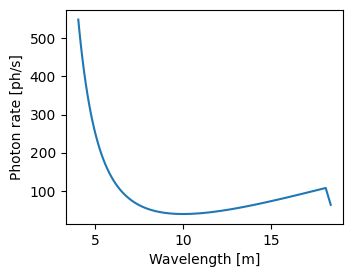

In [5]:
fig, ax = plt.subplots()

plt.plot(bus.data.inst['wl_bins'] * 1e6,
         instrument.inst.photon_rates_nchop['fundamental'].values ** 2 / setup['integration_time'])

# plt.yscale('log')
plt.xlabel('Wavelength [m]')
plt.ylabel('Photon rate [ph/s]')
plt.show()

# 2. Worst case: Alpha Cen

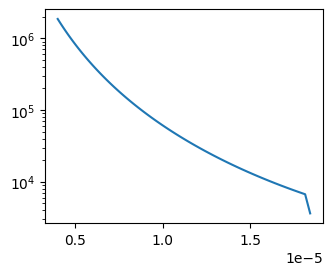

In [7]:
setup = {'temp_p': 255.,
         'radius_p': 1.,
         'distance_s': 1.33,
         'temp_s': 5891.,
         'radius_s': 1.22,
         'lat_s': 0.79,
         'z': 3.,
         'opt_wl': 15.,
         'spec_res': 50,
         'integration_time': 10 * 24 * 60 * 60,
         'exposure_time': 30 * 60,
         'nrot': 9,
         'hyperrot_noise': 'max',
         }

setup['angsep'] = 1 / setup['distance_s']
bus = lifesim.Bus()

# setting the options
bus.data.options.set_scenario('baseline')
bus.data.options.set_noise_scenario('earth-twin')
bus.data.options.set_manual(diameter=3., spec_res=50.)

# create modules and add to bus
instrument = lifesim.InstrumentPrt(name='inst')
bus.add_module(instrument)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

bus.connect(('inst', 'inst_base'))

instrument_base.apply_options()

fgamma = black_body(
    mode='planet',
    bins=bus.data.inst['wl_bins'],
    width=bus.data.inst['wl_bin_widths'],
    temp=setup['temp_p'],
    radius=setup['radius_p'],
    distance=setup['distance_s']
) / bus.data.inst['wl_bin_widths'] * u.photon / u.second / (u.meter ** 3)

flux_planet_spectrum = [bus.data.inst['wl_bins'] * u.meter, fgamma]

bus.data.options.set_manual(wl_optimal=setup['opt_wl'])
bus.data.options.set_manual(spec_res=setup['spec_res'])

instrument.apply_options(run_baseline=False)

res_in = instrument.get_spectrum(temp_s=setup['temp_s'],
                                 radius_s=setup['radius_s'],
                                 distance_s=setup['distance_s'],
                                 lat_s=setup['lat_s'],
                                 z=setup['z'],
                                 angsep=setup['angsep'],
                                 flux_planet_spectrum=flux_planet_spectrum,
                                 integration_time=setup['integration_time'],
                                 exposure_time=setup['exposure_time'],
                                 n_rot=setup['nrot'],
                                 # hyperrot_noise=setup['hyperrot_noise'],
                                 # get_single_bracewell=False,
                                 # verbose=True
                                 )
plt.plot(bus.data.inst['wl_bins'],
         instrument.inst.photon_rates_nchop['fundamental'].values ** 2 / setup['integration_time'])
plt.yscale('log')

# 3. Best case, localzodi only

/Users/fdannert/Documents/projects/InLIFEsim/InLIFEsim/inlifesim/util.py:67: RuntimeWarning: overflow encountered in exp
  fgamma = 2 * c / (x**4) / (np.exp(h * c / x / k / temp) - 1)


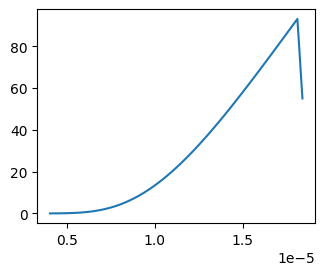

In [8]:
setup = {'temp_p': 255.,
         'radius_p': 1.,
         'distance_s': 10.,
         'temp_s': 10.,
         'radius_s': 0.001,
         'lat_s': 0.79,
         'z': 0.001,
         'opt_wl': 15.,
         'spec_res': 50,
         'integration_time': 10 * 24 * 60 * 60,
         'exposure_time': 30 * 60,
         'nrot': 9,
         'hyperrot_noise': 'max',
         }

setup['angsep'] = 1 / setup['distance_s']
bus = lifesim.Bus()

# setting the options
bus.data.options.set_scenario('baseline')
bus.data.options.set_noise_scenario('earth-twin')
bus.data.options.set_manual(diameter=3., spec_res=50.)

# create modules and add to bus
instrument = lifesim.InstrumentPrt(name='inst')
bus.add_module(instrument)

instrument_base = lifesim.Instrument(name='inst_base')
bus.add_module(instrument_base)

transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

exo = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exo)
local = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(local)
star = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star)

# connect all modules
bus.connect(('inst_base', 'transm'))
bus.connect(('inst_base', 'exo'))
bus.connect(('inst_base', 'local'))
bus.connect(('inst_base', 'star'))

bus.connect(('star', 'transm'))

bus.connect(('inst', 'inst_base'))

instrument_base.apply_options()

fgamma = black_body(
    mode='planet',
    bins=bus.data.inst['wl_bins'],
    width=bus.data.inst['wl_bin_widths'],
    temp=setup['temp_p'],
    radius=setup['radius_p'],
    distance=setup['distance_s']
) / bus.data.inst['wl_bin_widths'] * u.photon / u.second / (u.meter ** 3)

flux_planet_spectrum = [bus.data.inst['wl_bins'] * u.meter, fgamma]

bus.data.options.set_manual(wl_optimal=setup['opt_wl'])
bus.data.options.set_manual(spec_res=setup['spec_res'])

instrument.apply_options(run_baseline=False)

res_in = instrument.get_spectrum(temp_s=setup['temp_s'],
                                 radius_s=setup['radius_s'],
                                 distance_s=setup['distance_s'],
                                 lat_s=setup['lat_s'],
                                 z=setup['z'],
                                 angsep=setup['angsep'],
                                 flux_planet_spectrum=flux_planet_spectrum,
                                 integration_time=setup['integration_time'],
                                 exposure_time=setup['exposure_time'],
                                 n_rot=setup['nrot'],
                                 # hyperrot_noise=setup['hyperrot_noise'],
                                 # get_single_bracewell=False,
                                 # verbose=True
                                 )
plt.plot(bus.data.inst['wl_bins'],
         instrument.inst.photon_rates_nchop['fundamental'].values ** 2 / setup['integration_time'])

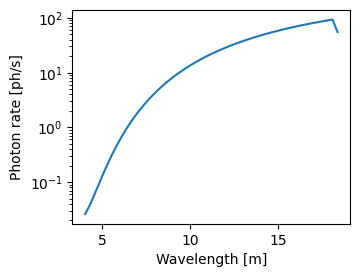

In [10]:
fig, ax = plt.subplots()

plt.plot(bus.data.inst['wl_bins'] * 1e6,
         instrument.inst.photon_rates_nchop['fundamental'].values ** 2 / setup['integration_time'])

plt.yscale('log')
plt.xlabel('Wavelength [m]')
plt.ylabel('Photon rate [ph/s]')
plt.show()

# 5. Double check with localzodi only simulation

In [11]:
from inlifesim.sources import create_localzodi
import astropy.units as u
import astropy.constants as const

Text(0.5, 0, 'Wavelength [$\\mu$m]')

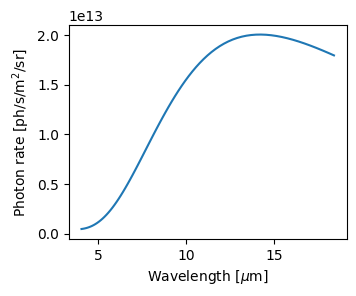

In [13]:
flux_lz = create_localzodi(wl_bins=bus.data.inst['wl_bins'],
                           wl_bin_widths=bus.data.inst['wl_bin_widths'],
                           lat=0.79)
# units: photon / s / m^2 / sr

plt.plot(bus.data.inst['wl_bins']*1e6, flux_lz / bus.data.inst['wl_bin_widths']/1e6)
plt.ylabel('Photon rate [ph/s/$\mathrm{m^2}$/sr]')
plt.xlabel('Wavelength [$\mu$m]')

In [14]:
jwst_measurement = pd.read_csv('/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/detector/jwst_zodi_measurements.csv')
jwst_model = pd.read_csv('/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/detector/jwst_zodi_model.csv')

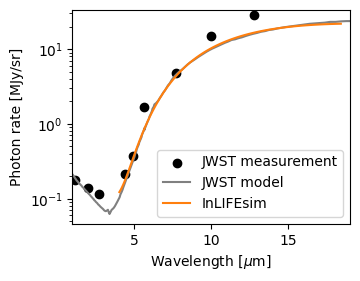

In [17]:
#convert to Jy
flux_lz_jy = flux_lz / bus.data.inst['wl_bin_widths'] * u.photon / (u.meter**3 * u.second * u.sr)

# back to energy units
flux_lz_jy *= const.c * const.h / (bus.data.inst['wl_bins'] * u.meter) / u.ph

flux_lz_jy = flux_lz_jy.to(u.Jy / u.sr, equivalencies=u.spectral_density(bus.data.inst['wl_bins']*u.meter))
# units: Jy / sr

fig, ax = plt.subplots()

plt.scatter(np.array(jwst_measurement['MIRI'].iloc[1:]).astype(float), 
            np.array(jwst_measurement['Unnamed: 1'].iloc[1:]).astype(float),
            color='k',
            label='JWST measurement')
plt.plot(np.array(jwst_model['Zodi-model'].iloc[1:]).astype(float), 
         np.array(jwst_model['Unnamed: 1'].iloc[1:]).astype(float),
         color='gray',
         label='JWST model')
plt.plot(bus.data.inst['wl_bins']*1e6, flux_lz_jy * 1e-6, c='tab:orange', label='InLIFEsim')
plt.ylabel('Photon rate [MJy/sr]')   
plt.xlabel('Wavelength [$\mu$m]')
plt.yscale('log')
plt.legend()
plt.xlim(1, 19)
fig.savefig('/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/detector/plots/localzodi_comparison.pdf', bbox_inches='tight')
plt.show()

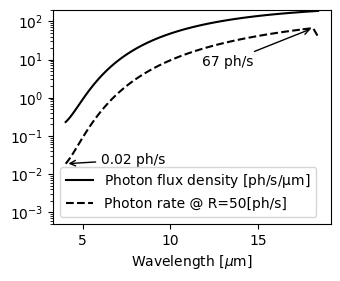

In [18]:
diameter_ap = 6
# note to eckhart: this is the equivalent aperture diameter of 4x3m mirrors

# amplitude response
A = np.sqrt(np.pi * (0.5 * diameter_ap) ** 2
                         * 0.05) # 5% throughput

# solid angle
omega = np.pi * (bus.data.inst['wl_bins']/(2. * diameter_ap))**2

pr_lz_nchop = flux_lz * A ** 2 * omega
# units: photon / s

fig, ax = plt.subplots()

plt.plot(bus.data.inst['wl_bins']*1e6, 
         pr_lz_nchop/(bus.data.inst['wl_bin_widths'] * 1e6), c='k',
         label='Photon flux density [ph/s/$\mathrm{\mu m}$]')
plt.plot(bus.data.inst['wl_bins']*1e6, 
         pr_lz_nchop, c='k', ls='--',
         label='Photon rate @ R=50[ph/s]')

# annotate minimum and maximum values of photon rate
plt.annotate(f'{np.min(pr_lz_nchop):.2f} ph/s',
             xy=(bus.data.inst['wl_bins'][np.argmin(pr_lz_nchop)]*1e6, np.min(pr_lz_nchop)),
             xytext=(bus.data.inst['wl_bins'][np.argmin(pr_lz_nchop)]*1e6*1.5, np.min(pr_lz_nchop)),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.annotate(f'{np.max(pr_lz_nchop):.0f} ph/s',
             xy=(bus.data.inst['wl_bins'][np.argmax(pr_lz_nchop)]*1e6, np.max(pr_lz_nchop)),
             xytext=(bus.data.inst['wl_bins'][np.argmax(pr_lz_nchop)]*1e6*0.65, np.max(pr_lz_nchop)*1e-1),
             arrowprops=dict(facecolor='black', arrowstyle='->'))




plt.xlabel('Wavelength [$\mu$m]')

plt.legend()
plt.yscale('log')

plt.ylim(5e-4, 2e2)
fig.savefig('/Users/fdannert/Documents/projects/InLIFEsim/working/nice_requirements/detector/plots/localzodi_validation_rate.pdf', bbox_inches='tight')
plt.show()